# League of Legends Professional Games Dataset 2015-2017
# EDA
# Michael Phillips

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', None)
%matplotlib inline

In [2]:
pk_df = pd.read_csv('player_kda.csv', index_col=0)
tk_df = pd.read_csv('team_kda.csv', index_col=0)
obj_df = pd.read_csv('object_sums.csv', index_col=0)
gen_df = pd.read_csv('merged_df.csv', index_col=0)
gm_df = pd.read_csv('gold_diff_merged.csv', index_col=0)
gt_df = pd.read_csv('gold_df_merged.csv', index_col=0)

## Total Wins, Losses, and Win Percentages

In [3]:
gen_df.head()

,match_id,league,season,year,team_name,red_or_blue_side,result,game_length,top_player,top_champ,jungle_player,jungle_champ,mid_player,mid_champ,adc_player,adc_champ,support_player,support_champ,ban_1,ban_2,ban_3,ban_4,ban_5
0,001a1f289e3bab22,LCK,Summer_Season,2015,ANC,blue,0,38,ikssu,Hecarim,lira,Gragas,Mickey,Vladimir,Sangyoon,Sivir,SnowFlower,Morgana,'Azir','Shyvana','Jayce',NaN,NaN
1,001a1f289e3bab22,LCK,Summer_Season,2015,CJE,red,1,38,Shy,Rumble,Ambition,Sejuani,Coco,Cassiopeia,Space,Jinx,Thresh,MadLife,'Zed','Gnar','Kalista',NaN,NaN
2,001f50c8547e2e73,Season_World_Championship,International,2014,EDG,blue,1,37,Koro1,Maokai,Clearlove,Rengar,U,Zed,NaMei,Twitch,Fzzf,Thresh,'Fizz','LeeSin','TwistedFate',NaN,NaN
3,001f50c8547e2e73,Season_World_Championship,International,2014,AHQ,red,0,37,Prydz,Nidalee,NAZ,Khazix,westdoor,Talon,GarnetDevil,Lucian,Blitzcrank,GreenTea,'Ryze','Zilean','Alistar',NaN,NaN
4,002f613ae09ad421,LMS,Spring_Season,2016,TPA,blue,1,30,Morning,Trundle,REFRA1N,RekSai,FoFo,Lissandra,BeBe,Lucian,Jay,Alistar,'Corki','Gangplank','TahmKench',NaN,NaN


In [31]:
results_df = pd.pivot_table(gen_df, index=['team_name'], aggfunc=np.sum)
results_df = results_df.reset_index()
results_df.drop(['game_length', 'year'], inplace=True, axis=1)
results_df = results_df.rename(columns = {'result':'wins'})
results_df.head()

,team_name,wins
0,AFs,73
1,AHQ,13
2,ALL,3
3,ANC,17
4,ANX,4


In [47]:
# count of rows per team, will give total games
total_df = pd.pivot_table(gen_df, index=['team_name'], aggfunc='count')
total_df = total_df.reset_index()

cols = ['team_name', 'result']
total_df = total_df[cols]

# combine wins, total games df
wl_df = pd.merge(results_df, total_df, on='team_name')
wl_df = wl_df.rename(columns = {'result':'total_games'})

# find losses, win percentage
wl_df['losses'] = wl_df.total_games - wl_df.wins
wl_df['win_pct'] = wl_df.wins / wl_df.total_games
cols = ['team_name', 'wins', 'losses', 'total_games', 'win_pct']
wl_df = wl_df[cols]
wl_df.head()

,team_name,wins,losses,total_games,win_pct
0,AFs,73,77,150,0.486667
1,AHQ,13,18,31,0.419355
2,ALL,3,3,6,0.500000
3,ANC,17,28,45,0.377778
4,ANX,4,6,10,0.400000


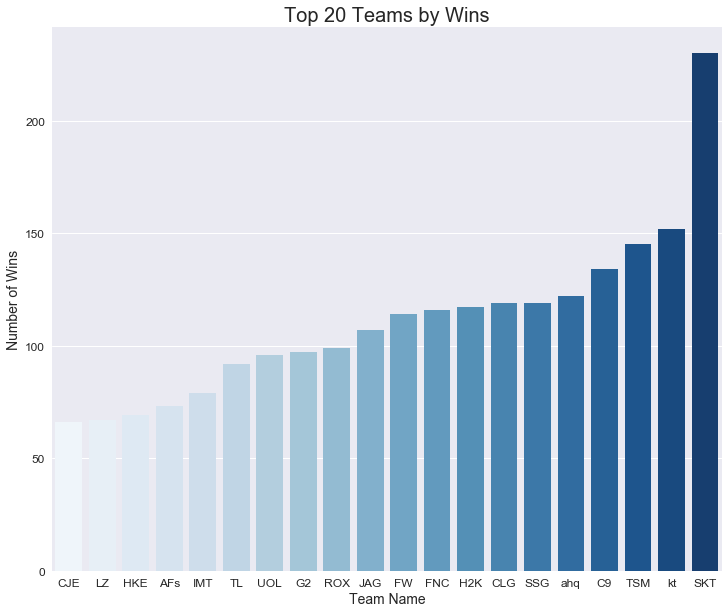

In [103]:
# sort wins for plotting
wins_df = wl_df[['team_name', 'wins']]
wins_df = wins_df.sort_values(by='wins')
wins_df = wins_df.tail(20)

# create plot
fig, ax = plt.subplots()
fig.set_size_inches(12, 10)
sns.barplot(x='team_name', y='wins', palette='Blues', data=wins_df);
plt.title("Top 20 Teams by Wins",fontsize=20)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.xlabel("Team Name", fontsize=14)
plt.ylabel("Number of Wins", fontsize=14);

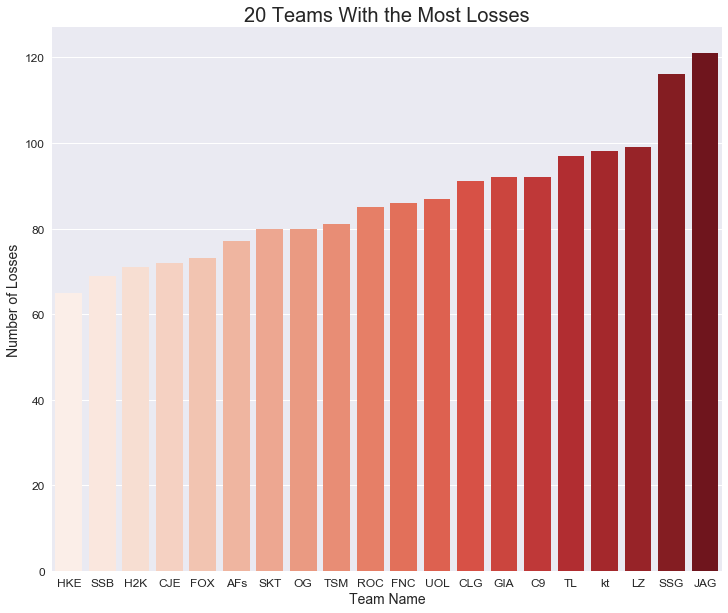

In [105]:
# sort losses for plotting
loss_df = wl_df[['team_name', 'losses']]
loss_df = loss_df.sort_values(by='losses')
loss_df = loss_df.tail(20)

# create plot
# create plot
fig, ax = plt.subplots()
fig.set_size_inches(12, 10)
sns.barplot(x='team_name', y='losses', palette='Reds', data=loss_df);
plt.title("20 Teams With the Most Losses",fontsize=20)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.xlabel("Team Name", fontsize=14)
plt.ylabel("Number of Losses", fontsize=14);

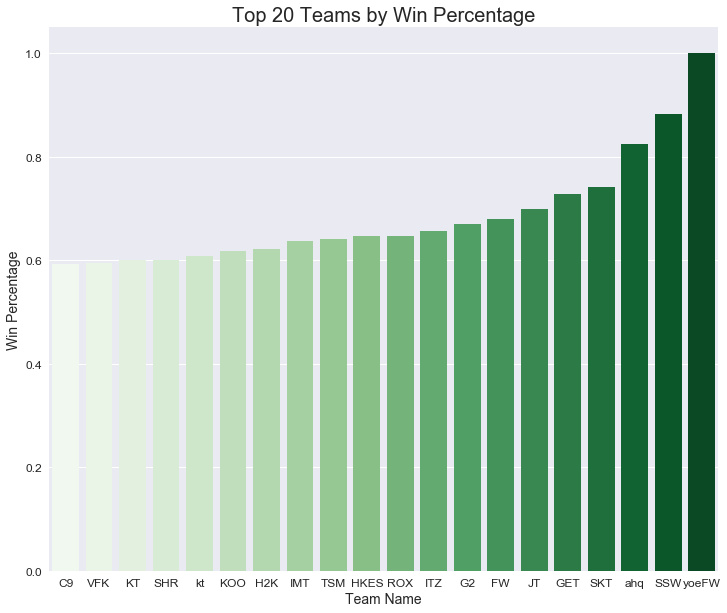

In [107]:
# sort losses for plotting
pct_df = wl_df[['team_name', 'win_pct']]
pct_df = pct_df.sort_values(by='win_pct')
pct_df = pct_df.tail(20)

# create plot
fig, ax = plt.subplots()
fig.set_size_inches(12, 10)
sns.barplot(x='team_name', y='win_pct', palette='Greens', data=pct_df);
plt.title("Top 20 Teams by Win Percentage",fontsize=20)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.xlabel("Team Name", fontsize=14)
plt.ylabel("Win Percentage", fontsize=14);